In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import os
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
sess = tf.Session()

def gaussian(x,sigma,mu):
    #分散共分散行列の行列式
    det = np.linalg.det(sigma)
    #分散共分散行列の逆行列
    inv = np.linalg.inv(sigma)
    n = x.ndim
    tmp = (x - mu).dot(inv)
    diag = np.sum(tmp*(x - mu),axis=1)
    return np.exp(-diag/2.0) / (np.sqrt((2 * np.pi) ** n * det))

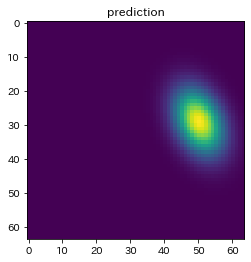

0.9971113980718153


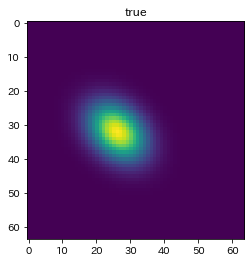

0.9999986216701844


In [3]:
X, Y = np.meshgrid(np.arange(0, 64, 1), np.arange(0, 64, 1)) # X座標,Y座標


img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[24,10],[10,42]]), [50,29]),[64,64])
# img = np.ones([64,64])/4096
plt.imshow(img)
plt.title("prediction")
plt.show()
print(np.sum(img))
x = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #予測値


img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[32,10],[10,32]]), [26,32]),[64,64])
plt.imshow(img)
plt.title("true")
plt.show()
print(np.sum(img))
y = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #真値

In [22]:
def compKL(p1,p2,smallV=1e-10):
    kl = tf.reduce_sum(p1*(tf.math.log(p1+smallV) - tf.math.log(p2+smallV)))
    return kl

def compSpatialHist(x,kSize=16,sSize=1,isNormMode='sum',thre=0.05):
    # binarize images
#     x_bin = tf.nn.relu(x - thre)
#     x_bin = tf.math.sign(x_bin)

    # kernel with all ones
    kernel = np.ones([kSize,kSize,1,1])
    kernel = tf.constant(kernel, dtype=tf.float64)

    # histogram using conv2d
    x_conv = tf.nn.conv2d(x,kernel,strides=[1,sSize,sSize,1],padding='SAME')
    shape = tf.shape(x_conv)
    x_conv_flat = tf.reshape(x_conv,[shape[0],shape[1]*shape[2]])

    if isNormMode == 'max':
        x_conv_flat = x_conv_flat/tf.reduce_max(x_conv_flat,axis=1,keepdims=True)
    elif isNormMode == 'sum':
        x_conv_flat = x_conv_flat/tf.reduce_sum(x_conv_flat,axis=1,keepdims=True)

    x_conv = tf.reshape(x_conv_flat,[shape[0],shape[1],shape[2]])

    return x_conv

hist_x = compSpatialHist(x)
hist_y = compSpatialHist(y)

In [23]:
kl_loss = compKL(hist_x,hist_y)
grad = tf.gradients(kl_loss,x)[0]

sess.run(tf.global_variables_initializer())

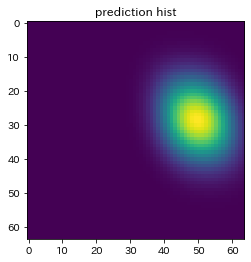

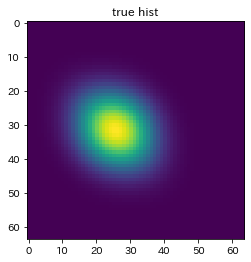

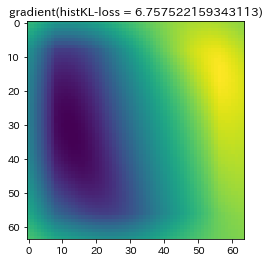

[[-3.59555966 -4.0866446  -4.58413132 ...  1.0764991   0.93292888
   0.79492801]
 [-4.1192196  -4.68162687 -5.25136793 ...  1.30637045  1.13747572
   0.97431705]
 [-4.65613785 -5.29166719 -5.9354917  ...  1.55280859  1.35788252
   1.16842844]
 ...
 [-3.2880989  -3.78546709 -4.30474328 ...  0.16455395  0.25414586
   0.31997561]
 [-2.90395458 -3.34197584 -3.79977965 ...  0.10371752  0.18712636
   0.24908591]
 [-2.5408986  -2.92218342 -3.32108948 ...  0.05042251  0.12718701
   0.1847944 ]]


In [24]:
hist_x_value, hist_y_value, grad_value, kl_value = sess.run([hist_x,hist_y,grad,kl_loss])

img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[24,10],[10,42]]), [50,29]),[64,64])

plt.imshow(hist_x_value[0])
plt.title("prediction hist")
plt.show()

plt.imshow(hist_y_value[0])
plt.title("true hist")
plt.show()

plt.imshow(grad_value[0,:,:,0])
plt.title("gradient(histKL-loss = {})".format(kl_value))
plt.show()

print(grad_value[0,:,:,0])